In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
#读取数据集
train = pd.read_csv('../input/home-data-for-ml-course/train.csv')
test = pd.read_csv('../input/home-data-for-ml-course/test.csv')

In [3]:
train.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:

test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# id这一列对于模型预测是没有用的，先将它在训练集和测试集中去掉

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [6]:
#合并train test数据一起处理
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [7]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

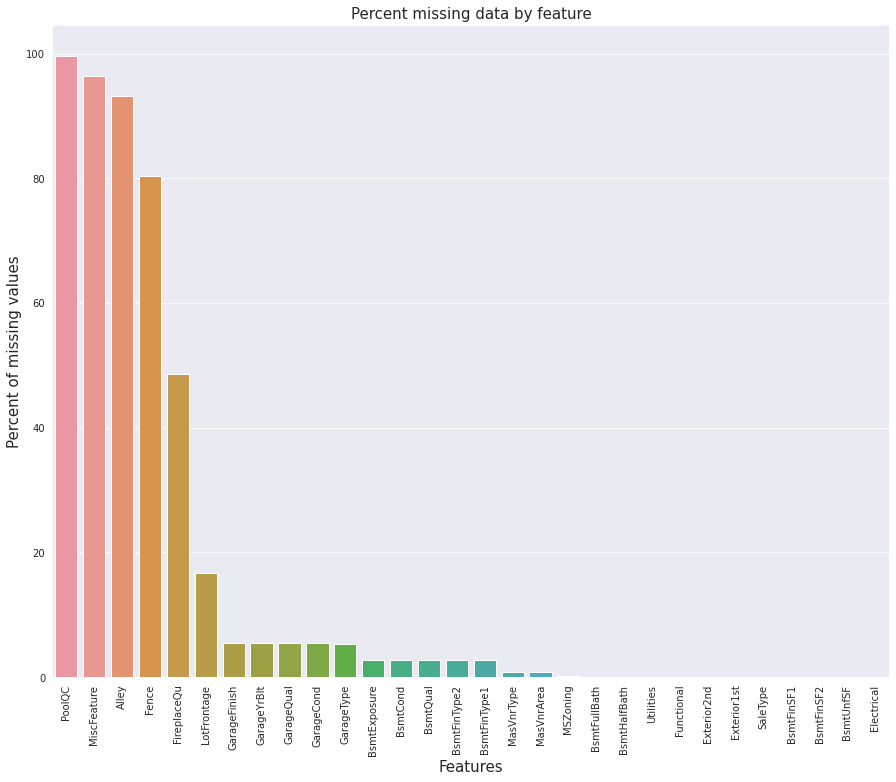

In [8]:
#将缺失度用图表的方式展示
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

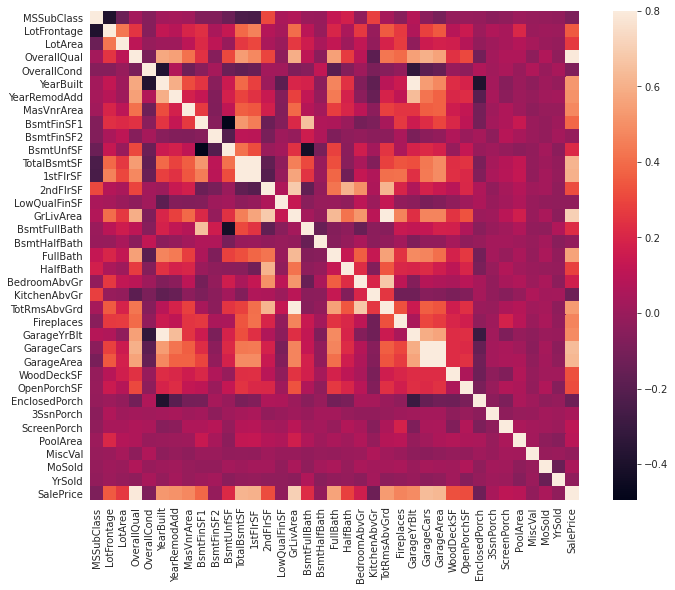

In [9]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

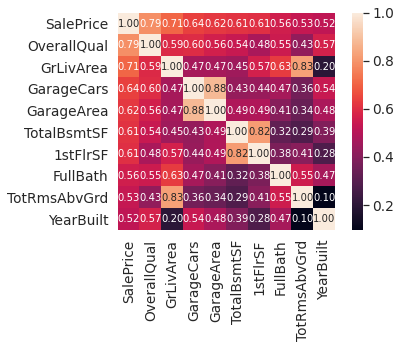

In [10]:
#选出10个与房价相关性最强的变量查看相关性系数

k = 10 #选择变量的个数
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


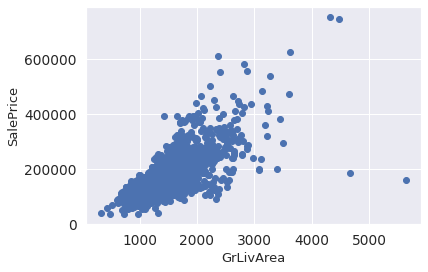

In [11]:
#GrLivArea代表含义是居住面积，发现和房价有比较明显的正相关关系
#我们可以在右下角看到两个明显的outlier，价格很低，但面积巨大，我们可以考虑删除掉这两个异常值。
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

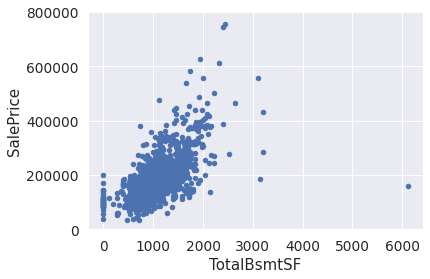

In [12]:

#TotalBsmtSF含义为地下室面积，发现地下室面积与房价似乎有更强的潜在线性关系，同时在右侧似乎也有一个异常值存在
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

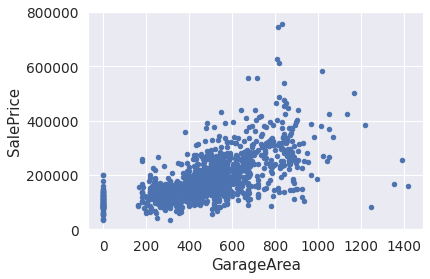

In [13]:
#GarageArea含义为车库面积，可以看到车库面积和房价也存在一定的正相关关系
var = 'GarageArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

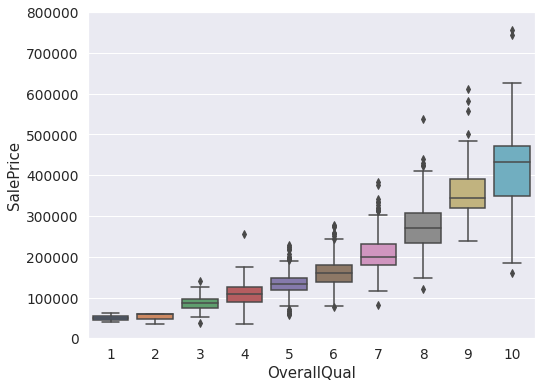

In [14]:
# 首先看一下房屋质量和房价之间的关系，可以看到随着房屋整体质量的变好，房屋的整体价格也在逐渐提高，是一个比较强力的预测变量
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

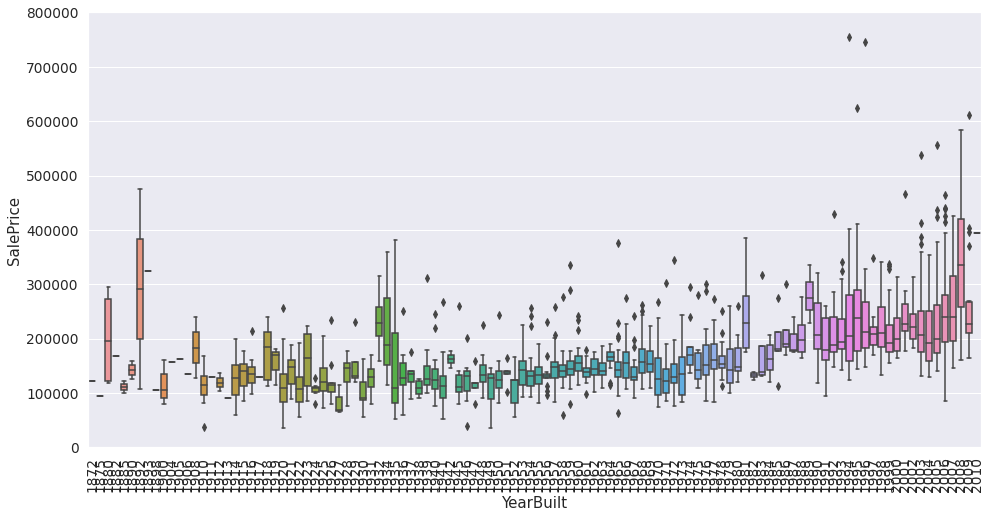

In [15]:
#再看一下房屋的建造时间和价格的关系，可以看到房屋的建造时间虽然没有和房价有明显的线性关系，但最近建造的新房屋，整体的价格会比较高，这个在后面的特征工程中会用到，注意

var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

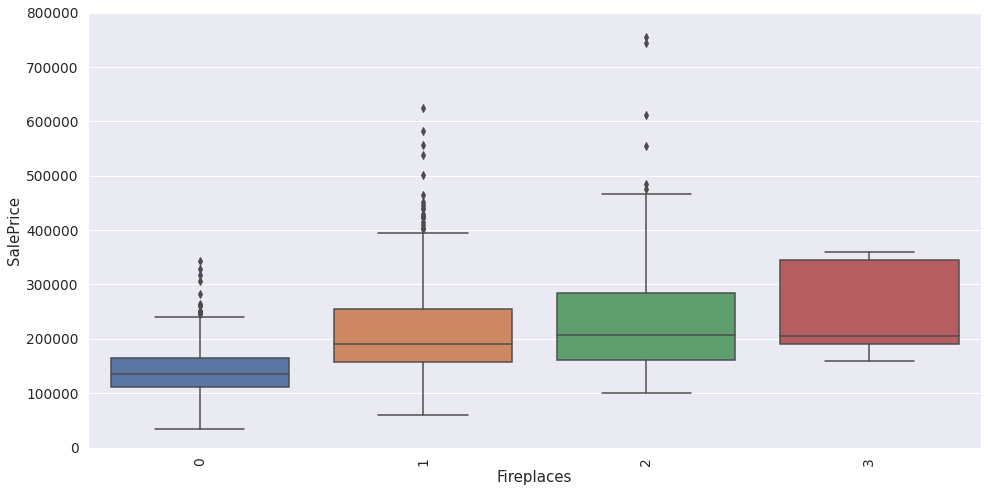

In [16]:
#上面是一些比较容易想到的变量，我们可以再看一下壁炉数量和房价的关系，壁炉越多，房价越高
var = 'Fireplaces'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

## **二、数据处理**

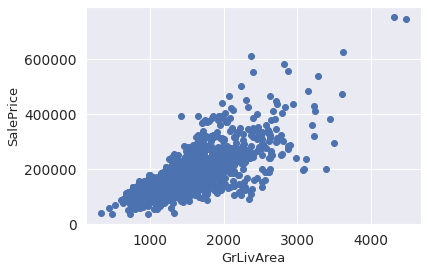

In [17]:
#删除掉异常值
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

##对异常值进行删除重新画图，可以看到异常值没有了，在这里我们只看了一个变量，有兴趣的同学也可以看一下其他的变量异常值的分布情况。
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

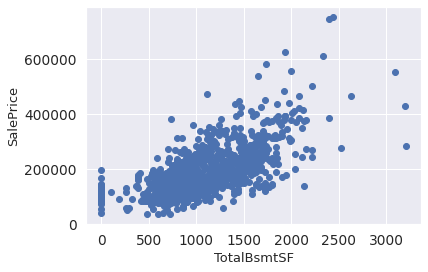

In [18]:
#对于地下室面积，做同样处理
train = train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<200000)].index)

fig, ax = plt.subplots()
ax.scatter(train['TotalBsmtSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

In [19]:
#异常值的分布情况
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(50)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


In [20]:
#PoolQC、MiscFeature、Alley的缺失值都在90%以上，可以考虑直接删掉这些特征
all_data= all_data.drop('PoolQC',axis=1)
all_data = all_data.drop('MiscFeature',axis=1)
all_data= all_data.drop('Alley',axis=1)

#删掉这3列后，变量变成了76列
all_data.shape

(2919, 76)

In [21]:
#Fence栅栏，FireplaceQu壁炉，如果数据缺失的话可能是代表房屋没有栅栏或壁炉， 我们用None填补缺失值，代表没有
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [22]:
#LotFrontage代表房屋前街道的长度，从现实中考虑，房屋前街道的长度可能是会和房屋所在一个街区的房屋相同，所以我们可以考虑同一个街区房屋
#LotFrontage的均值来填补缺失值

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [23]:
#Garage相关的车库变量，注意到这些变量的缺失比例是完全相同的，缺失这些变量的房屋可能是没有车库，用None填充
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [24]:
#同样猜测缺失值缺失的原因可能是因为房屋没有车库，对于连续型变量用0填充
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [25]:
#地下室相关连续变量，缺失同样认为房屋可能是没有地下室，用0填充
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [26]:
#地下室相关离散变量，同理用None填充
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [27]:
#Mas为砖石结构相关变量，缺失值我们同样认为是没有砖石结构，用0和none填补缺失值
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [28]:
#MSZoning代表房屋所处的用地类型，给大家先看一下不同取值的个数
#可以看到RL的取值最多，
all_data.groupby('MSZoning')['MasVnrType'].count().reset_index()

,MSZoning,MasVnrType
0,C (all),25
1,FV,139
2,RH,26
3,RL,2265
4,RM,460


In [29]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [30]:
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [31]:
#检查还有没有缺失值
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio



 mu = 180932.92 and sigma = 79467.79



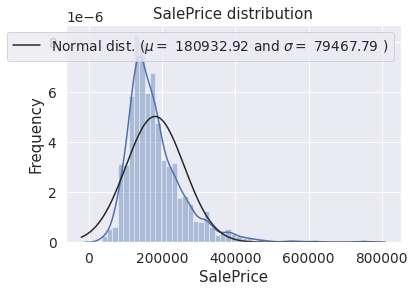

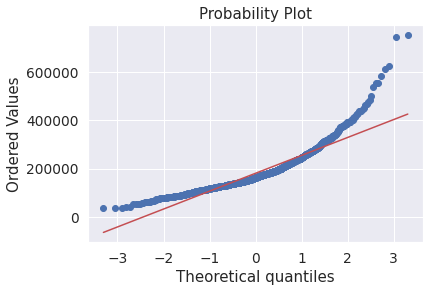

In [32]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



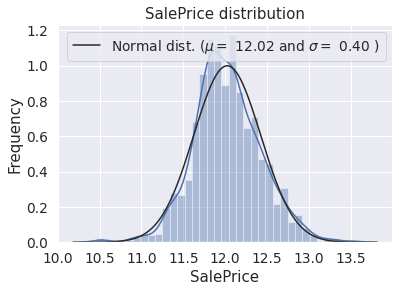

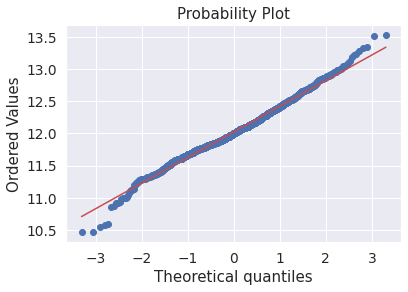

In [33]:
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## **三、特征工程**

In [34]:
#加地下室面积、1楼面积、2楼面积加起来可以得到房屋总面积特征
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
#之前可视化时候注意到，建造时间比较近的房子房价比较高，所以新创造一个01特征，如果房屋建造时间在1990年后，则为1，否则是0
all_data['YearBuilt_cut'] = all_data['YearBuilt'].apply(lambda x:1 if x>1990 else 0)

In [35]:
tep = all_data[:ntrain]
tep['SalePrice'] = y_train

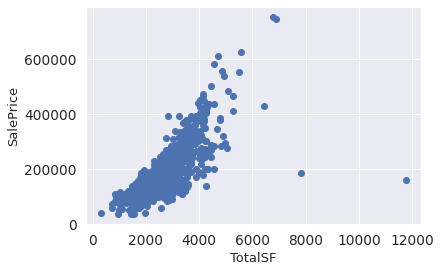

In [36]:
#房屋总面积特征，发现与房价有比较强的线性关系，但也有2个可能的异常值，可以考虑再去掉这两个异常值
fig, ax = plt.subplots()
ax.scatter(tep['TotalSF'], tep['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalSF', fontsize=13)
plt.show()

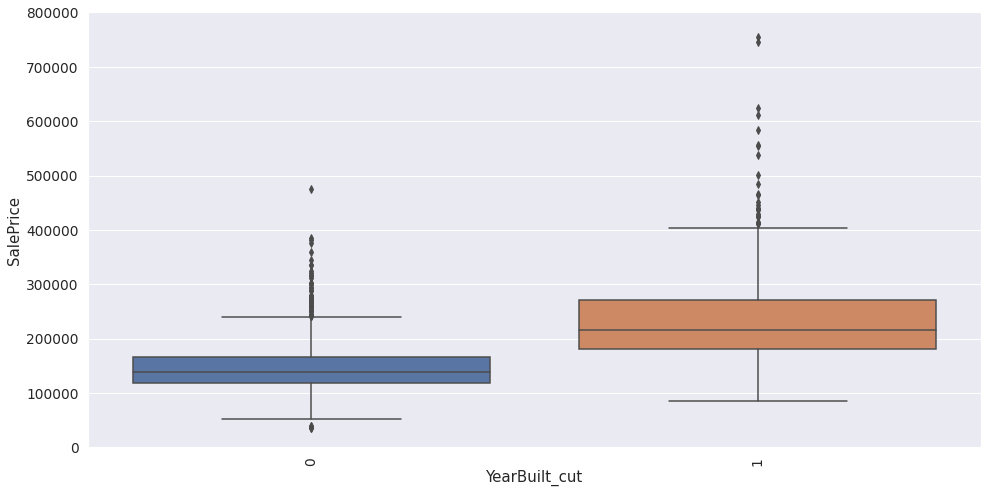

In [37]:
#建筑年限，可以看到1990年前建造的房子和1990后建造的房子房价在分布上有较大的差异
var = 'YearBuilt_cut'
data = pd.concat([tep['SalePrice'], tep[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [38]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 77)


In [39]:
all_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,YearBuilt_cut
0,5,RL,65.0,8450,1,3,Lvl,Inside,0,CollgCr,...,0,0,None,0,1,2,WD,Normal,2566.0,1
1,0,RL,80.0,9600,1,3,Lvl,FR2,0,Veenker,...,0,0,None,0,4,1,WD,Normal,2524.0,0
2,5,RL,68.0,11250,1,0,Lvl,Inside,0,CollgCr,...,0,0,None,0,8,2,WD,Normal,2706.0,1
3,6,RL,60.0,9550,1,0,Lvl,Corner,0,Crawfor,...,0,0,None,0,1,0,WD,Abnorml,2473.0,0
4,5,RL,84.0,14260,1,0,Lvl,FR2,0,NoRidge,...,0,0,None,0,11,2,WD,Normal,3343.0,1


In [40]:
#数据集中还有部分非有序性离散变量，我们将他们转换成哑变量的形式（和onehot一个意思）
all_data = pd.get_dummies(all_data)

In [41]:
all_data.shape

(2919, 219)

In [42]:
all_data.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5,65.0,8450,1,3,0,7,4,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,0,80.0,9600,1,3,0,6,7,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,5,68.0,11250,1,0,0,7,4,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,6,60.0,9550,1,0,0,7,4,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,1,0,0,8,4,2000,2000,...,0,0,0,1,0,0,0,0,1,0


In [43]:
# 特征筛选

threshold = 0.9

#相关性矩阵
corr_matrix = all_data.corr().abs()
corr_matrix.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSSubClass,1.000000,0.365568,0.193132,0.002709,0.065225,0.028488,0.048596,0.065277,0.037721,0.043707,...,0.004326,0.046509,0.014294,0.048228,0.001164,0.028103,0.061658,0.016628,0.024333,0.051562
LotFrontage,0.365568,1.000000,0.387612,0.046753,0.156113,0.064669,0.210123,0.059130,0.123801,0.087066,...,0.040872,0.110685,0.003486,0.082034,0.004117,0.046761,0.007862,0.015088,0.080383,0.108461
LotArea,0.193132,0.387612,1.000000,0.133936,0.181812,0.334575,0.100541,0.035617,0.024128,0.021612,...,0.015732,0.031601,0.004067,0.013592,0.014771,0.020429,0.024241,0.017927,0.022898,0.033434
Street,0.002709,0.046753,0.133936,1.000000,0.017584,0.093744,0.072424,0.018160,0.062184,0.080520,...,0.003368,0.019187,0.003150,0.006029,0.016953,0.004128,0.172024,0.008130,0.012266,0.019448
LotShape,0.065225,0.156113,0.181812,0.017584,1.000000,0.087731,0.259034,0.069531,0.281031,0.191105,...,0.015897,0.078430,0.008115,0.035889,0.048239,0.025181,0.027610,0.022270,0.006304,0.076399


In [44]:
#只选择矩阵的上半部分
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSSubClass,NaN,0.365568,0.193132,0.002709,0.065225,0.028488,0.048596,0.065277,0.037721,0.043707,...,0.004326,0.046509,0.014294,0.048228,0.001164,0.028103,0.061658,0.016628,0.024333,0.051562
LotFrontage,NaN,NaN,0.387612,0.046753,0.156113,0.064669,0.210123,0.059130,0.123801,0.087066,...,0.040872,0.110685,0.003486,0.082034,0.004117,0.046761,0.007862,0.015088,0.080383,0.108461
LotArea,NaN,NaN,NaN,0.133936,0.181812,0.334575,0.100541,0.035617,0.024128,0.021612,...,0.015732,0.031601,0.004067,0.013592,0.014771,0.020429,0.024241,0.017927,0.022898,0.033434
Street,NaN,NaN,NaN,NaN,0.017584,0.093744,0.072424,0.018160,0.062184,0.080520,...,0.003368,0.019187,0.003150,0.006029,0.016953,0.004128,0.172024,0.008130,0.012266,0.019448
LotShape,NaN,NaN,NaN,NaN,NaN,0.087731,0.259034,0.069531,0.281031,0.191105,...,0.015897,0.078430,0.008115,0.035889,0.048239,0.025181,0.027610,0.022270,0.006304,0.076399


In [45]:
#有6列特征需要删掉
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 6 columns to remove.


In [46]:
all_data = all_data.drop(columns = to_drop)
all_data.shape

(2919, 213)

In [47]:
#之前是把train和test数据集放在一起处理，现在再把他们分开
train = all_data[:ntrain]
test = all_data[ntrain:]

## **四、建模**

In [48]:
#导入一些所需要的包
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [49]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


In [50]:
#导入ridge模型
model_ridge = Ridge()

In [51]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

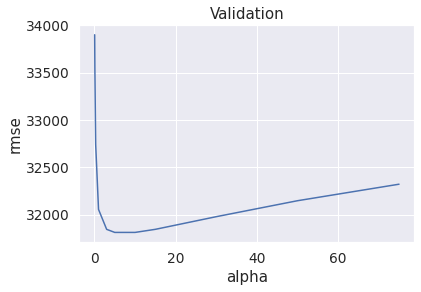

In [52]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [53]:
cv_ridge

0.05     33899.763851
0.10     33539.201017
0.30     32738.482115
1.00     32053.913904
3.00     31843.231925
5.00     31810.779484
10.00    31810.821182
15.00    31843.447482
30.00    31977.123335
50.00    32145.754785
75.00    32320.269291
dtype: float64

In [54]:
#alpha参数用我们之前验证过的5,然后用训练集对模型进行训练
clf = Ridge(alpha=5)
clf.fit(train,y_train)

Ridge(alpha=5)

In [55]:
predict = clf.predict(test)

In [56]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = predict
sub.head(10)
sub.to_csv('submission.csv',index=False)